In [1]:
import numpy as np
import re
import string
from nltk.corpus import twitter_samples, stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

In [3]:
stopwords_english = stopwords.words('english')
stemmer = PorterStemmer()

tweets_train = positive_tweets[:2000] + negative_tweets[:2000]
tweets_test = positive_tweets[2000:] + negative_tweets[2000:]

labels_train = np.append(np.ones(len(positive_tweets[:2000])), np.zeros(len(negative_tweets[:2000])))
labels_test = np.append(np.ones(len(positive_tweets[2000:])), np.zeros(len(negative_tweets[2000:])))

def process_tweet(tweet):
  tweet = re.sub(r'^RT[\s]+', '', tweet)
  tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
  tweet = re.sub(r'#', '', tweet)

  tokenizer = TweetTokenizer(
    preserve_case=False, # deixa tudo minúsculo
    strip_handles=True, # remove @ dos usuários
    reduce_len=True # não deixa uma letra se repetir mais de 3 vezes em sequência, ex.: looouco .. -> looouco .. / leeeeeeite ..... -> leeeite ...
  )

  tweet_tokens = tokenizer.tokenize(tweet)

  tweets_clean = []

  for word in tweet_tokens:
    if (word not in stopwords_english and word not in string.punctuation):
      tweets_clean.append(word)

  tweets_stem = [] 

  for word in tweets_clean:
    stem_word = stemmer.stem(word)
    tweets_stem.append(stem_word)

  return tweets_stem

In [4]:
tweets_train_processed = []

for tweet in tweets_train:
  tweets_train_processed.append(process_tweet(tweet))

tweets_test_processed = []

for tweet in tweets_test:
  tweets_test_processed.append(process_tweet(tweet))

In [5]:
tweets_train_processed[0]

['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']

In [6]:
frequency_dictionary = {} # word: [pos, neg]

for tweet_index in range(len(tweets_train_processed)):
  for word in tweets_train_processed[tweet_index]:
    label = labels_train[tweet_index]

    pos = 1 if label == 1 else 0
    neg = 1 if label == 0 else 0

    if word in frequency_dictionary:
      pos += frequency_dictionary[word][0]
      neg += frequency_dictionary[word][1]

    frequency_dictionary[word] = [pos, neg]

In [7]:
X_train = []

for tweet in tweets_train_processed:
  tweet_vector = []
  
  for word in tweet:
    tweet_vector.append(frequency_dictionary[word])

  X_train.append(tweet_vector)

X_test = []

for tweet in tweets_test_processed:
  tweet_vector = []
  
  for word in tweet:
    if word in frequency_dictionary:
      tweet_vector.append(frequency_dictionary[word])
    else:
      tweet_vector.append([0, 0])

  X_test.append(tweet_vector)

14.0


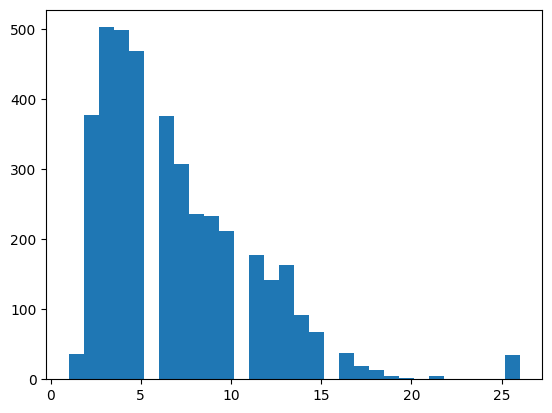

In [8]:
tweets_len = []

for tweet in X_train:
  tweets_len.append(len(tweet))

print(np.percentile(tweets_len, 95))
plt.hist(tweets_len, bins=30)
plt.show()

#### Vamos padronizar os tweets para terem tamanho 14

In [9]:
size = int(np.percentile(tweets_len, 95))

for index in range(len(X_train)):
  tweet_len = len(X_train[index])

  if size > tweet_len:
    rows_to_add = np.zeros((size - tweet_len, 2), dtype=int)

    X_train[index] = np.vstack((X_train[index], rows_to_add))
  else:
    X_train[index] = X_train[index][:size]

for index in range(len(X_test)):
  tweet_len = len(X_test[index])

  if size > tweet_len:
    rows_to_add = np.zeros((size - tweet_len, 2), dtype=int)

    X_test[index] = np.vstack((X_test[index], rows_to_add))
  else:
    X_test[index] = X_test[index][:size]

#### Fazer o Reshape para caber na Logistic Regression, vai ficar (amostras, 14 * 3)

In [10]:
X_train_reshape = np.reshape(X_train, (len(X_train), -1))
X_test_reshape = np.reshape(X_test, (len(X_test), -1))

c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      3000
         1.0       0.98      0.98      0.98      3000

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



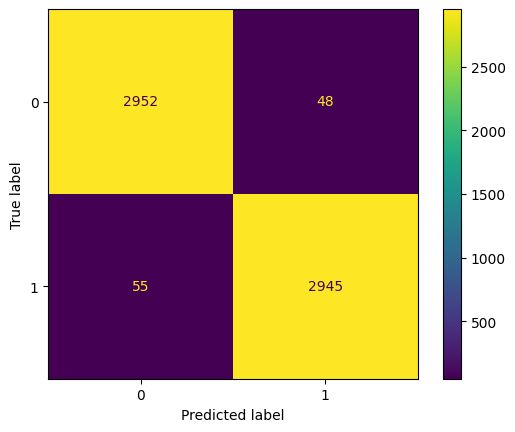

In [11]:
model = LogisticRegression()
model.fit(X_train_reshape, labels_train)
y_pred = model.predict(X_test_reshape)

print(classification_report(labels_test, y_pred))

cm = confusion_matrix(labels_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()